In [1]:
!pip install tensorflow

In [4]:
!pip install matplotlib

In [5]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [6]:
import os
os.chdir('/kaggle/input/landslide4sense')

In [7]:
# Testing the dataset 
path_single = "/kaggle/input/landslide4sense/TrainData/img/image_1.h5"
path_single_mask = '/kaggle/input/landslide4sense/TrainData/mask/mask_1.h5'

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


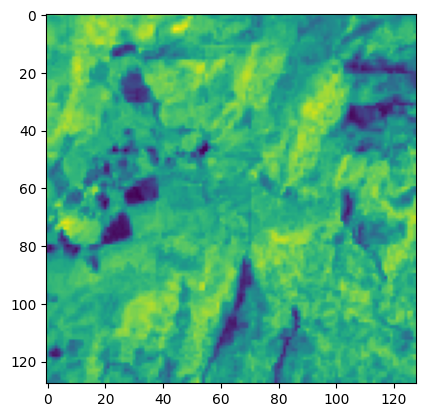

In [8]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


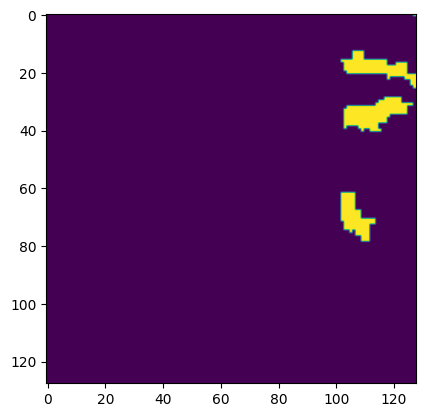

In [9]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [10]:
path_single = "/kaggle/input/landslide4sense/TrainData/img/image_1.h5"
path_single_mask = "/kaggle/input/landslide4sense/TrainData/mask/mask_1.h5"
TRAIN_PATH = "/kaggle/input/landslide4sense/TrainData/img/*.h5"
TRAIN_MASK = "/kaggle/input/landslide4sense/TrainData/mask/*.h5"

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [11]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
    
    
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

0 /kaggle/input/landslide4sense/TrainData/img/image_1.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1.h5
1 /kaggle/input/landslide4sense/TrainData/img/image_10.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_10.h5
2 /kaggle/input/landslide4sense/TrainData/img/image_100.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_100.h5
3 /kaggle/input/landslide4sense/TrainData/img/image_1000.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1000.h5
4 /kaggle/input/landslide4sense/TrainData/img/image_1001.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1001.h5
5 /kaggle/input/landslide4sense/TrainData/img/image_1002.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1002.h5
6 /kaggle/input/landslide4sense/TrainData/img/image_1003.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1003.h5
7 /kaggle/input/landslide4sense/TrainData/img/image_1004.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_1004.h5
8 /kaggle/input/landslide4sense/TrainData/img/image_1005.h5 /kaggle/

<ipython-input-12-b831676fb87b>:25: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE


1674 /kaggle/input/landslide4sense/TrainData/img/image_2505.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2505.h5
1675 /kaggle/input/landslide4sense/TrainData/img/image_2506.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2506.h5
1676 /kaggle/input/landslide4sense/TrainData/img/image_2507.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2507.h5
1677 /kaggle/input/landslide4sense/TrainData/img/image_2508.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2508.h5
1678 /kaggle/input/landslide4sense/TrainData/img/image_2509.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2509.h5
1679 /kaggle/input/landslide4sense/TrainData/img/image_251.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_251.h5
1680 /kaggle/input/landslide4sense/TrainData/img/image_2510.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2510.h5
1681 /kaggle/input/landslide4sense/TrainData/img/image_2511.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_2511.h5
1682 /kaggle/input/landslide4sense

<ipython-input-12-b831676fb87b>:18: RuntimeWarning: divide by zero encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
<ipython-input-12-b831676fb87b>:18: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


2268 /kaggle/input/landslide4sense/TrainData/img/image_304.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_304.h5
2269 /kaggle/input/landslide4sense/TrainData/img/image_3040.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3040.h5
2270 /kaggle/input/landslide4sense/TrainData/img/image_3041.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3041.h5
2271 /kaggle/input/landslide4sense/TrainData/img/image_3042.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3042.h5
2272 /kaggle/input/landslide4sense/TrainData/img/image_3043.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3043.h5
2273 /kaggle/input/landslide4sense/TrainData/img/image_3044.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3044.h5
2274 /kaggle/input/landslide4sense/TrainData/img/image_3045.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3045.h5
2275 /kaggle/input/landslide4sense/TrainData/img/image_3046.h5 /kaggle/input/landslide4sense/TrainData/mask/mask_3046.h5
2276 /kaggle/input/landslide4sense

In [13]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


In [14]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

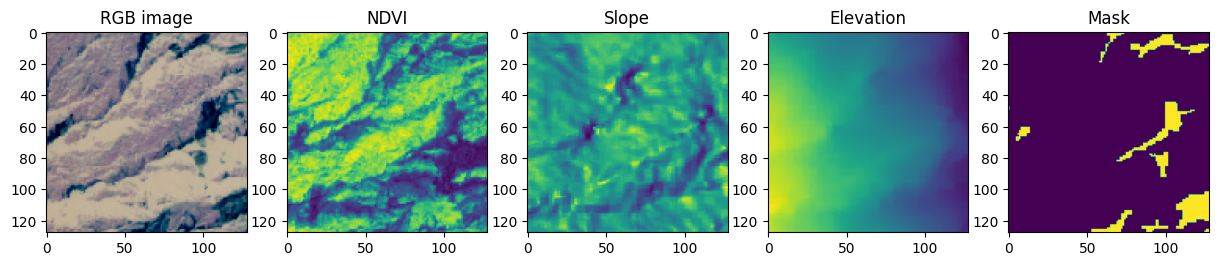

In [15]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

In [16]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

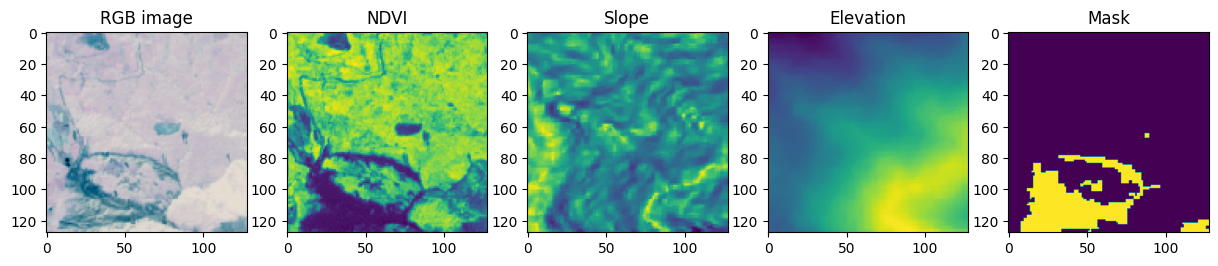

In [17]:
img=155
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [18]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [19]:
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

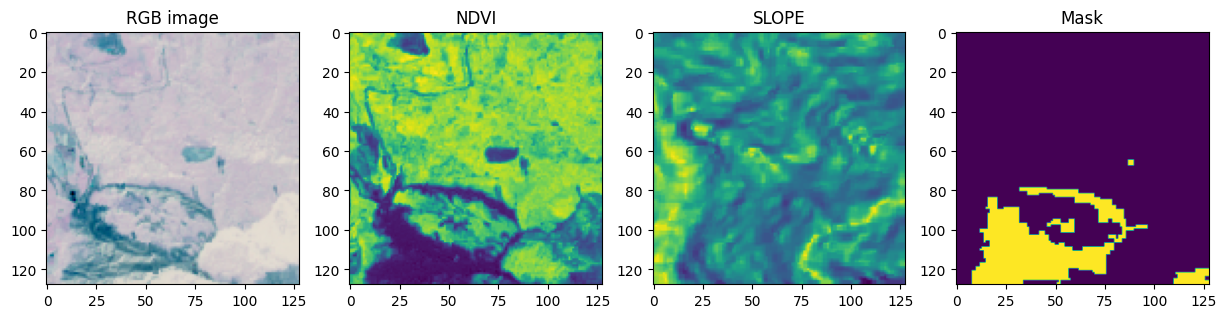

In [20]:
img=155
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

In [21]:
import sys
sys.path.append("/kaggle/input/utils-file/utils")  

from utils import recall_m, precision_m, f1_m

def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

In [22]:
model = unet_model(128, 128, 6)

# Define ModelCheckpoint to save the best model based on val_f1_m
checkpointer = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")

# Define any additional callbacks (e.g., EarlyStopping)
callbacks = [
    # earlyStopping,
    checkpointer
]

# Train the model
history = model.fit(x_train, y_train, batch_size=16,  
                    epochs=100, 
                    verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=callbacks)

# Save the final model (this can still be saved to /kaggle/working/ with .h5 if needed)
model.save("/kaggle/working/model_save.h5")


Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.59345, saving model to /kaggle/working/best_model.keras
190/190 - 47s - 248ms/step - accuracy: 0.9788 - f1_m: 0.3507 - loss: 0.0734 - precision_m: 0.5989 - recall_m: 0.2867 - val_accuracy: 0.9820 - val_f1_m: 0.5935 - val_loss: 0.0495 - val_precision_m: 0.6858 - val_recall_m: 0.5367
Epoch 2/100

Epoch 2: val_f1_m improved from 0.59345 to 0.63619, saving model to /kaggle/working/best_model.keras
190/190 - 7s - 39ms/step - accuracy: 0.9834 - f1_m: 0.5587 - loss: 0.0453 - precision_m: 0.6996 - recall_m: 0.4942 - val_accuracy: 0.9839 - val_f1_m: 0.6362 - val_loss: 0.0431 - val_precision_m: 0.7134 - val_recall_m: 0.5823
Epoch 3/100

Epoch 3: val_f1_m improved from 0.63619 to 0.64800, saving model to /kaggle/working/best_model.keras
190/190 - 7s - 39ms/step - accuracy: 0.9849 - f1_m: 0.5970 - loss: 0.0399 - precision_m: 0.7112 - recall_m: 0.5309 - val_accuracy: 0.9851 - val_f1_m: 0.6480 - val_loss: 0.0387 - val_precision_m: 0.7665 - val_r

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.037745874375104904 0.9875306487083435 0.7161850929260254 0.8261793255805969 0.6346781253814697


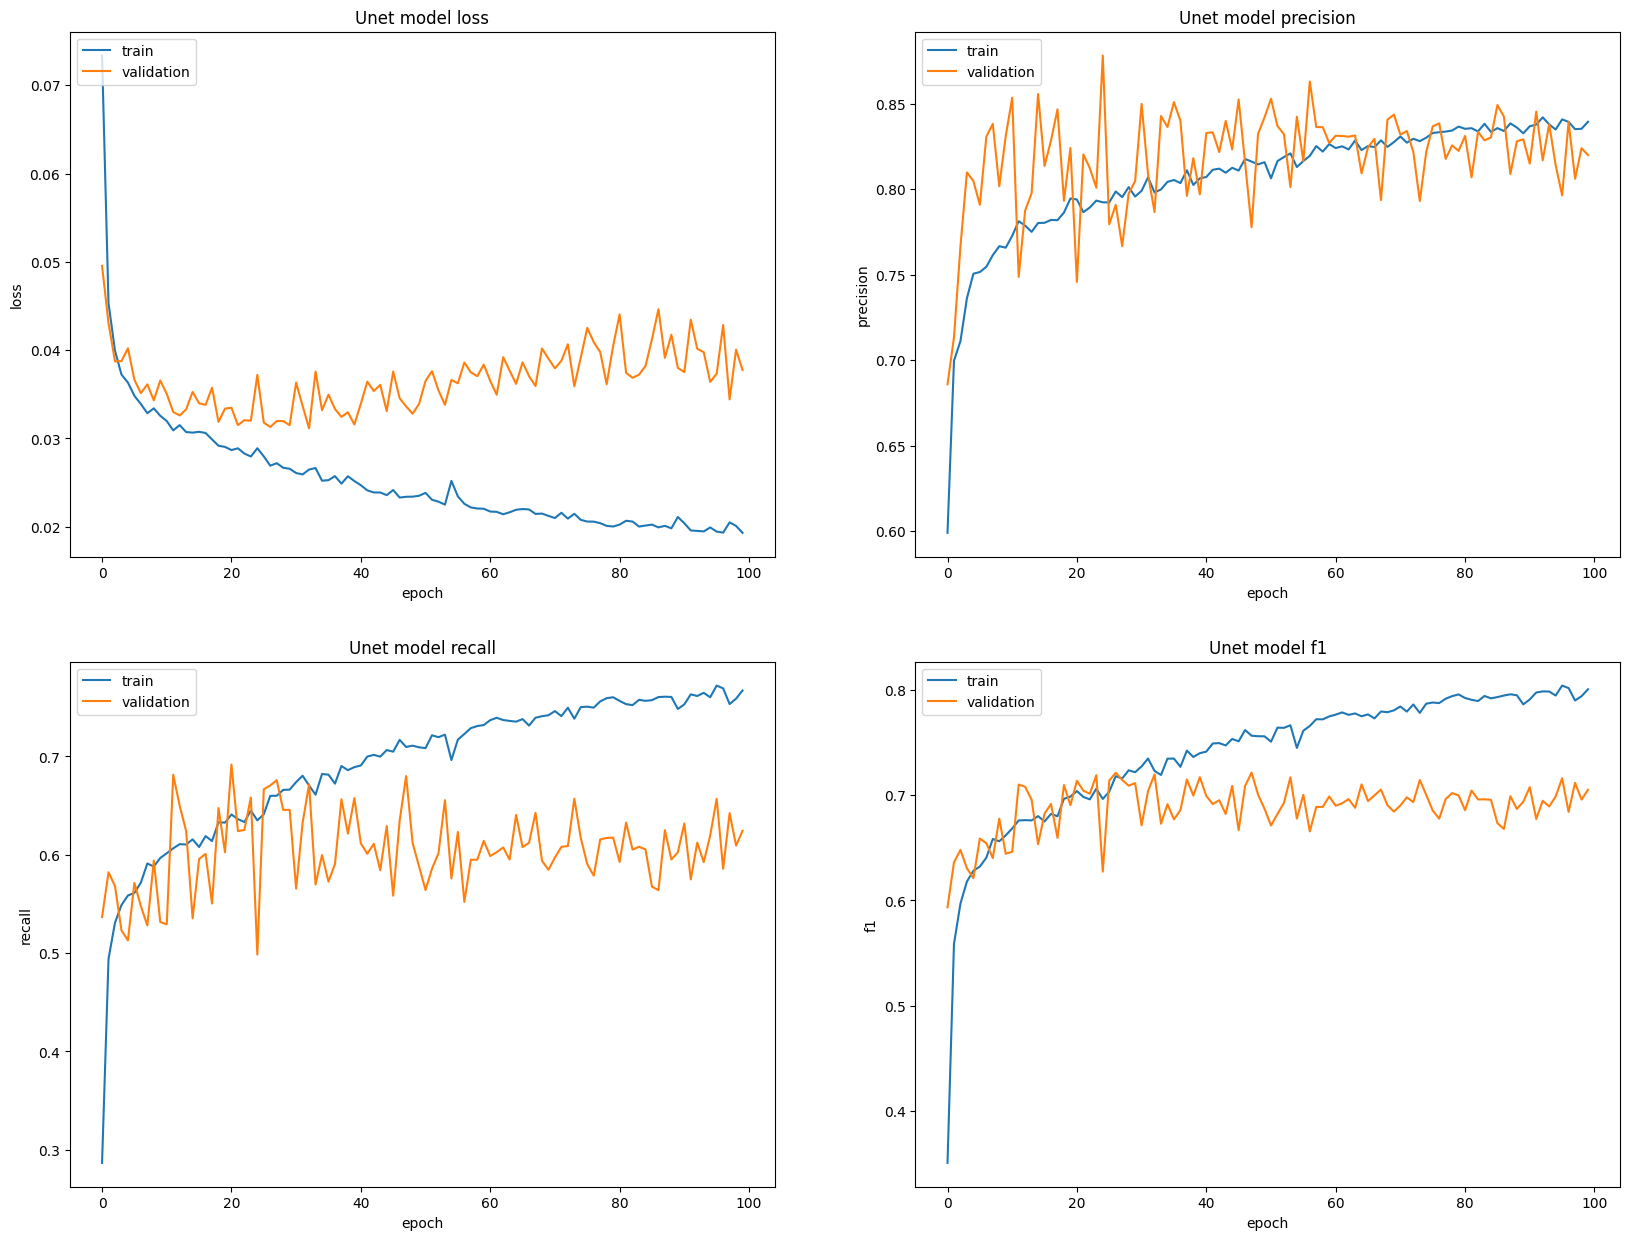

In [24]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [25]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


Text(0.5, 1.0, 'Training Image')

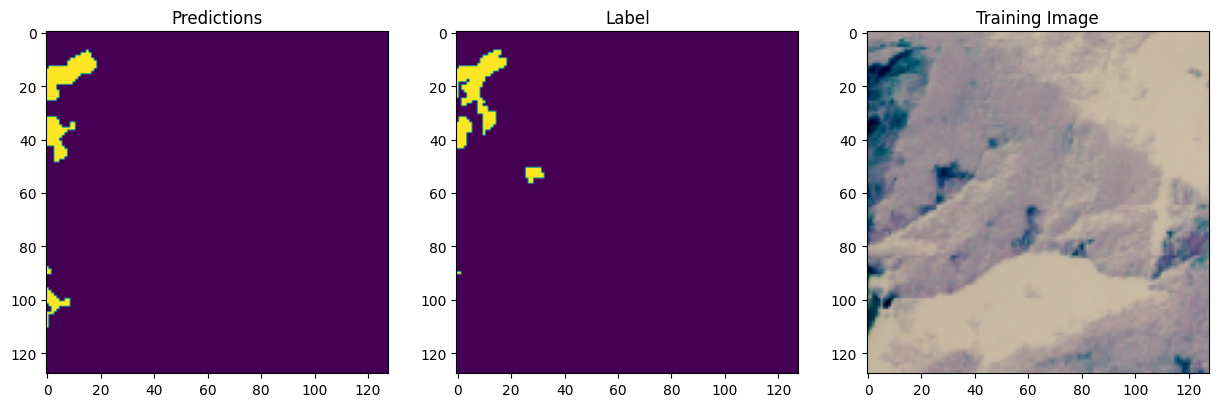

In [26]:
img = 155
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [27]:
validation_url = "/kaggle/input/landslide4sense/ValidData/img/*.h5"
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 /kaggle/input/landslide4sense/ValidData/img/image_1.h5
1 /kaggle/input/landslide4sense/ValidData/img/image_10.h5
2 /kaggle/input/landslide4sense/ValidData/img/image_100.h5
3 /kaggle/input/landslide4sense/ValidData/img/image_101.h5
4 /kaggle/input/landslide4sense/ValidData/img/image_102.h5
5 /kaggle/input/landslide4sense/ValidData/img/image_103.h5
6 /kaggle/input/landslide4sense/ValidData/img/image_104.h5
7 /kaggle/input/landslide4sense/ValidData/img/image_105.h5
8 /kaggle/input/landslide4sense/ValidData/img/image_106.h5
9 /kaggle/input/landslide4sense/ValidData/img/image_107.h5
10 /kaggle/input/landslide4sense/ValidData/img/image_108.h5
11 /kaggle/input/landslide4sense/ValidData/img/image_109.h5
12 /kaggle/input/landslide4sense/ValidData/img/image_11.h5
13 /kaggle/input/landslide4sense/ValidData/img/image_110.h5
14 /kaggle/input/landslide4sense/ValidData/img/image_111.h5
15 /kaggle/input/landslide4sense/ValidData/img/image_112.h5
16 /kaggle/input/landslide4sense/ValidData/img/image_1

<ipython-input-27-ba5fee1be569>:24: RuntimeWarning: divide by zero encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
<ipython-input-27-ba5fee1be569>:24: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


161 /kaggle/input/landslide4sense/ValidData/img/image_244.h5
162 /kaggle/input/landslide4sense/ValidData/img/image_245.h5
163 /kaggle/input/landslide4sense/ValidData/img/image_25.h5
164 /kaggle/input/landslide4sense/ValidData/img/image_26.h5
165 /kaggle/input/landslide4sense/ValidData/img/image_27.h5
166 /kaggle/input/landslide4sense/ValidData/img/image_28.h5
167 /kaggle/input/landslide4sense/ValidData/img/image_29.h5
168 /kaggle/input/landslide4sense/ValidData/img/image_3.h5
169 /kaggle/input/landslide4sense/ValidData/img/image_30.h5
170 /kaggle/input/landslide4sense/ValidData/img/image_31.h5
171 /kaggle/input/landslide4sense/ValidData/img/image_32.h5
172 /kaggle/input/landslide4sense/ValidData/img/image_33.h5
173 /kaggle/input/landslide4sense/ValidData/img/image_34.h5
174 /kaggle/input/landslide4sense/ValidData/img/image_35.h5
175 /kaggle/input/landslide4sense/ValidData/img/image_36.h5
176 /kaggle/input/landslide4sense/ValidData/img/image_37.h5
177 /kaggle/input/landslide4sense/Valid

In [28]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step


<ipython-input-28-72ffe7cc9193>:3: RuntimeWarning: invalid value encountered in greater
  pred_img = (pred_img > threshold).astype(np.uint8)


(245, 128, 128, 1)

Text(0.5, 1.0, 'Training Image')

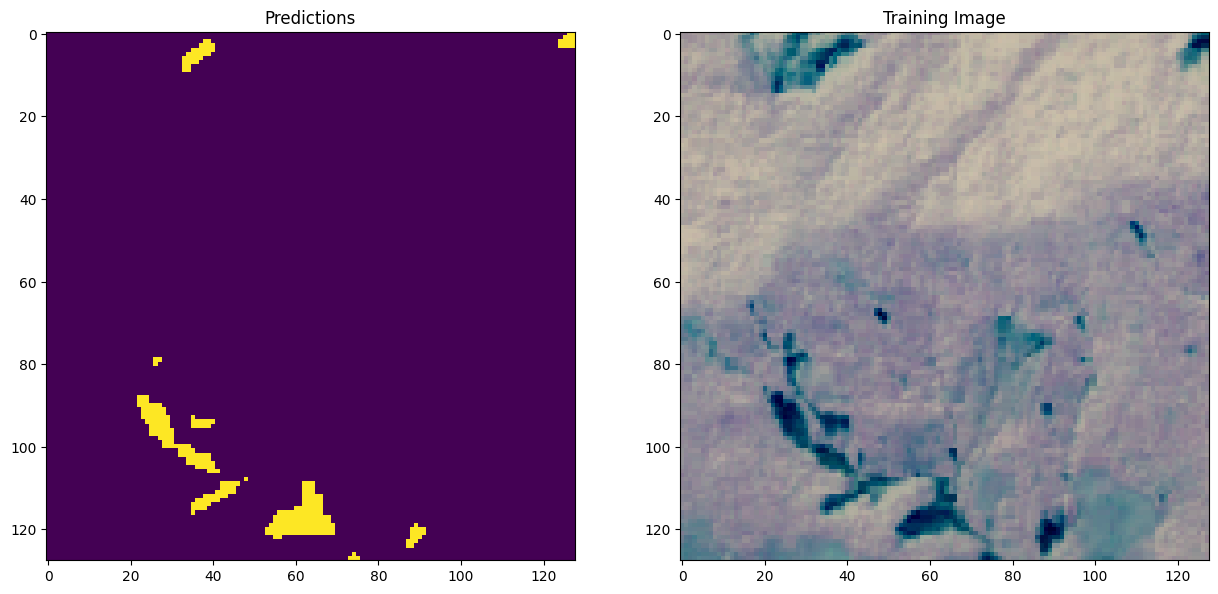

In [29]:
img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

In [30]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("/kaggle/working/best_model.keras", custom_objects={'dice_loss': dice_loss, 'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})


In [31]:
def preprocess_image(path):
    with h5py.File(path, 'r') as hdf:
        data = np.array(hdf.get('img'))

        # Normalize the data as done in training
        data[np.isnan(data)] = 0.000001
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # Calculate NDVI
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

        # Prepare the input format
        input_data = np.zeros((1, 128, 128, 6))
        input_data[0, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # Red
        input_data[0, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # Green
        input_data[0, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # Blue
        input_data[0, :, :, 3] = data_ndvi  # NDVI
        input_data[0, :, :, 4] = 1 - data[:, :, 12] / mid_slope  # Slope
        input_data[0, :, :, 5] = 1 - data[:, :, 13] / mid_elevation  # Elevation

    return input_data

# Example: Load a new image
wayanad_image = preprocess_image("/kaggle/input/landslide4sense/TestData/img/image_113.h5")
kozhikode_image = preprocess_image("/kaggle/input/landslide4sense/TestData/img/image_125.h5")


In [32]:
# Predict landslide risk for Wayanad and Kozhikode
wayanad_pred = model.predict(wayanad_image)
kozhikode_pred = model.predict(kozhikode_image)

# Threshold the predictions to obtain binary masks (landslide or no landslide)
wayanad_mask = (wayanad_pred[0, :, :, 0] > 0.5).astype(np.uint8)
kozhikode_mask = (kozhikode_pred[0, :, :, 0] > 0.5).astype(np.uint8)

print("Prediction for Wayanad:", wayanad_mask.shape)
print("Prediction for Kozhikode:", kozhikode_mask.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction for Wayanad: (128, 128)
Prediction for Kozhikode: (128, 128)


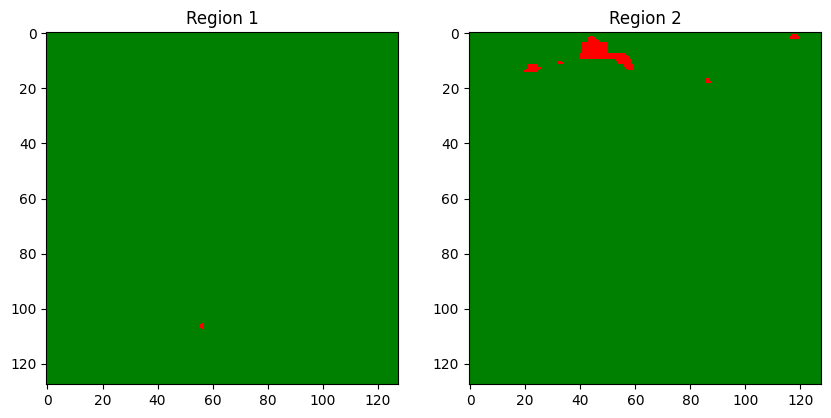

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define a custom colormap: green for no landslide, red for landslide
cmap = ListedColormap(['green', 'red'])

# Plot the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Region 1")
ax1.imshow(wayanad_mask, cmap=cmap)

ax2.set_title("Region 2")
ax2.imshow(kozhikode_mask, cmap=cmap)

plt.show()

